In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [4]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [10]:
list_of_tickers = ["SPY", "AGG"]
# YOUR CODE HERE
# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for SPY and AGG
IEXCLOUD_df = get_historical_data(list_of_tickers, start_date, end_date, close_only=True, output_format='pandas')
#df = get_historical_data(list_of_tickers, start_date, end_date, close_only=True, output_format='pandas')
IEXCLOUD_df.head()

SPY                AGG         
             close     volume   close   volume
date                                          
2019-01-22  262.86  115531183  106.44  6823956
2019-01-23  263.41   86030287  106.55  3222846
2019-01-24  263.55   59204139  106.73  7308898
2019-01-25  265.78   96883358  106.68  3469453
2019-01-28  263.76   85613655  106.62  7365747

In [11]:
#Saving the data to a csv file created with the IEXCLOUD extract, to avoid multiple IEXCLOUD requests
IEXCLOUD_df.drop(columns=['volume'], level=1, inplace=True)
IEXCLOUD_df.columns=["SPY", "AGG"]
IEXCLOUD_df.to_csv("../Resources/IEXCLOUD_data.csv", encoding='utf-8')#, index=False)

In [37]:
#Getting the data from a csv file created with the IEXCLOUD extract, to avoid multiple IEXCLOUD requests
from pathlib import Path
IEXCLOUD_csv = Path("../Resources/IEXCLOUD_data.csv")
IEXCLOUD_df = pd.read_csv(IEXCLOUD_csv, index_col="date", parse_dates=True, infer_datetime_format=True)
IEXCLOUD_df.tail()

,SPY,AGG
date,,
2020-01-13,327.95,112.91
2020-01-14,327.45,113.01
2020-01-15,328.19,113.18
2020-01-16,330.92,113.18
2020-01-17,331.95,113.05


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [38]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_returns = IEXCLOUD_df.pct_change()
daily_returns.head()

,SPY,AGG
date,,
2019-01-22,NaN,NaN
2019-01-23,0.002092,0.001033
2019-01-24,0.000531,0.001689
2019-01-25,0.008461,-0.000468
2019-01-28,-0.007600,-0.000562


In [39]:
# Calculate volatility
# YOUR CODE HERE
avg_daily_return_SPY = daily_returns.mean()['SPY']
avg_daily_return_AGG = daily_returns.mean()['AGG']
print (f"Avg return SPY             Avg return AGG")
print (f"{avg_daily_return_SPY} ---- {avg_daily_return_AGG}")
std_daily_return_SPY = daily_returns.std()['SPY']
std_daily_return_AGG = daily_returns.std()['AGG']
print ("------------------------------------------------------")
print (f"STD daily returns SPY     STD daily returns AGG")
print (f"{std_daily_return_SPY} ---- {std_daily_return_AGG}")

Avg return SPY             Avg return AGG
0.0009612642291769476 ---- 0.00024318932345666555
------------------------------------------------------
STD daily returns SPY     STD daily returns AGG
0.007401574798510325 ---- 0.002084866830981002


In [40]:
# Save the last day's closing price
# YOUR CODE HERE
SPY_last_close = IEXCLOUD_df["SPY"][-1]
AGG_last_close = IEXCLOUD_df["AGG"][-1]
print (f"{SPY_last_close} ---- {AGG_last_close}")

331.95 ---- 113.05


In [41]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

In [42]:
# Run the Monte Carlo Simulation
monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()

for x in range(number_simulations):
    # YOUR CODE HERE
    simulated_SPY_prices = [SPY_last_close]
    simulated_AGG_prices = [AGG_last_close]
    # Simulate the returns for 252*30 days
    for i in range(number_records):
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_daily_return_SPY))
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_daily_return_AGG))
        
        # Append the simulated price to the list
        simulated_SPY_prices.append(simulated_SPY_price)
        simulated_AGG_prices.append(simulated_AGG_price)
        
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo[f"Simulation {x}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
monte_carlo.head()

,Simulation 0,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,...,Simulation 490,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002765,0.996222,0.993929,0.999896,1.005468,1.006505,1.008854,0.996870,1.001856,0.999339,...,1.002160,0.996121,1.006918,1.000176,0.997978,1.003057,0.996650,0.994530,1.003012,0.997636
2,1.007598,1.000038,0.993478,0.999056,1.008655,0.998236,1.003838,0.987116,1.001268,1.007326,...,1.004317,1.003128,1.009988,1.001913,0.999475,1.000177,0.996370,0.995111,1.003086,1.001348
3,1.007033,1.000251,0.996933,0.993854,1.008206,1.001209,1.007665,0.981654,1.001242,1.015214,...,1.004537,1.005779,1.014524,1.003520,0.993478,0.999223,1.000070,1.000454,1.006429,1.000479
4,1.015419,1.003153,0.993831,0.999488,1.009844,0.996768,1.006748,0.979196,1.008793,1.006011,...,1.006454,1.004336,1.013382,1.008449,0.999416,0.996601,0.994983,1.001323,1.010826,1.003931


In [43]:
monte_carlo.tail()

,Simulation 0,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,...,Simulation 490,Simulation 491,Simulation 492,Simulation 493,Simulation 494,Simulation 495,Simulation 496,Simulation 497,Simulation 498,Simulation 499
7556,173.843549,141.905878,189.423358,201.991178,185.681424,151.139272,176.944556,273.302193,190.832346,204.959919,...,62.377395,201.141070,121.750544,186.054719,225.996547,254.636073,77.737669,168.664499,290.663475,81.758727
7557,173.635217,142.374102,189.884071,201.881787,184.466286,151.064775,176.100499,274.880521,189.911832,204.712954,...,61.905035,201.065781,121.566346,186.645430,225.947220,256.160643,78.439097,168.741236,293.296026,81.332823
7558,172.941952,142.430788,191.494692,202.039808,184.976791,151.278464,176.517465,275.307411,191.153351,204.080454,...,61.871456,202.074799,121.655061,187.289684,227.209306,255.432291,78.391515,167.730378,295.068103,80.985607
7559,172.718865,143.324670,192.131712,202.272850,184.943209,151.974377,176.526637,274.712114,191.420969,203.414304,...,62.237632,202.974775,120.735684,186.105102,227.634979,254.704396,79.169344,167.589997,296.033571,80.990230
7560,172.632754,143.860225,193.515796,202.454611,185.436230,152.304804,176.366583,273.569820,191.242121,203.405026,...,62.316923,203.962048,120.252352,187.609201,227.884661,254.921807,78.888951,166.441114,294.108973,81.142151


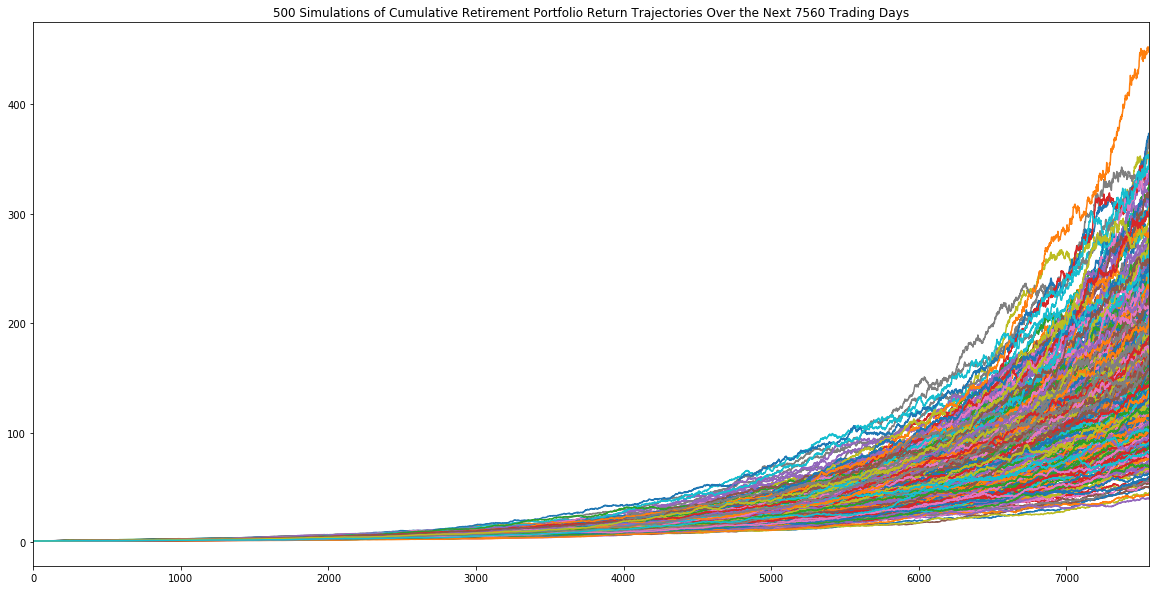

In [56]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{x+1} Simulations of Cumulative Retirement Portfolio Return Trajectories Over the Next 7560 Trading Days"
monte_carlo.plot(legend=None, title=plot_title, figsize=(20,10))

In [57]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
portfolio_cumulative_returns_30 = monte_carlo.iloc[-1, :]
portfolio_cumulative_returns_30.head()

Simulation 0    172.632754
Simulation 1    143.860225
Simulation 2    193.515796
Simulation 3    202.454611
Simulation 4    185.436230
Name: 7560, dtype: float64

In [58]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
portfolio_cumulative_returns_20 = monte_carlo.iloc[-2521, :]
portfolio_cumulative_returns_20.head()

Simulation 0    25.353314
Simulation 1    27.885583
Simulation 2    22.060370
Simulation 3    30.396539
Simulation 4    34.013887
Name: 5040, dtype: float64

In [60]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = portfolio_cumulative_returns_30.quantile(q=[0.1, 0.9])
confidence_interval

0.1     92.882554
0.9    237.622657
Name: 7560, dtype: float64

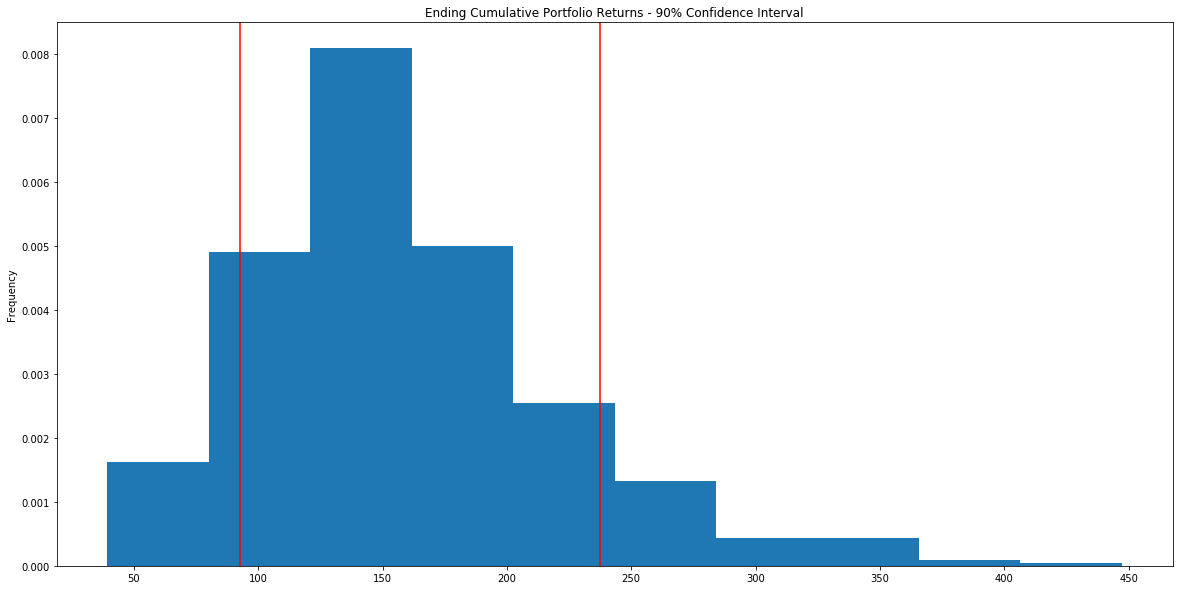

In [61]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE
plt.figure();
portfolio_cumulative_returns_30.plot(kind='hist', title= "Ending Cumulative Portfolio Returns - 90% Confidence Interval", density=True, bins=10, figsize=(20,10))
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [49]:
# YOUR CODE HERE

#Percentiles 10 & 90
confidence_interval_10_90 = portfolio_cumulative_returns_30.quantile(q=[0.1, 0.9])
print(confidence_interval_10_90)
confidence_interval_50_50 = portfolio_cumulative_returns_30.quantile(q=[0.5, 0.5])
print(confidence_interval_50_50)

0.1     92.882554
0.9    237.622657
Name: 7560, dtype: float64
0.5    147.0429
0.5    147.0429
Name: 7560, dtype: float64


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [50]:
# YOUR CODE HERE

# Set initial investment
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_10 = initial_investment * confidence_interval_10_90.iloc[0]
investment_pnl_90 = initial_investment * confidence_interval_10_90.iloc[1]

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_50 = initial_investment * confidence_interval_50_50.iloc[0]
                                                    
# Print the results
print("-----------------------------------------------------------------------------")
print(f"There is a 10% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end with a value of"
      f" ${investment_pnl_10}")
print(f"There is a 50% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end with a value of"
      f" ${investment_pnl_50}")
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end with a value of"
      f" ${investment_pnl_90}")
print("-----------------------------------------------------------------------------")

-----------------------------------------------------------------------------
There is a 10% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end with a value of $1857651.0827897505
There is a 50% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end with a value of $2940857.993288653
There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end with a value of $4752453.136497456
-----------------------------------------------------------------------------


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [51]:
# YOUR CODE HERE
current_projected_annual_income = 7389 #taken from account_summary.ipynb
withdraw_rate = 0.04
ammount_10 = withdraw_rate * investment_pnl_10
print (f"4% of retirement portfolio at the 10th percentile is ${ammount_10}")
print (f"Current Projected annual income is ${current_projected_annual_income}")
if ammount_10 >= current_projected_annual_income:
    print(f"Withdrawing 4% at 10th Percentile will cover the income with no issues")
else:
    print(f"Withdrawing 4% at 10th Percentile will NOT cover the needed income!!!!")

4% of retirement portfolio at the 10th percentile is $74306.04331159002
Current Projected annual income is $7389
Withdrawing 4% at 10th Percentile will cover the income with no issues


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [52]:
# YOUR CODE HERE
#50% increase in the initial investment means an initial investment of $30.000

# Set initial investment
initial_investment = 30000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_10 = initial_investment * confidence_interval_10_90.iloc[0]
investment_pnl_90 = initial_investment * confidence_interval_10_90.iloc[1]
# Print the results
print("-----------------------------------------------------------------------------")
print(f"There is a 10% chance that an initial investment of $30,000 in the portfolio"
      f" over the next 30 years will end with a value of"
      f" ${investment_pnl_10}")
print("-----------------------------------------------------------------------------")
current_projected_annual_income = 7389 #taken from account_summary.ipynb
withdraw_rate = 0.04
ammount_10 = withdraw_rate * investment_pnl_10
print (f"4% of retirement portfolio at the 10th percentile is ${ammount_10}")
print (f"Current Projected annual income is ${current_projected_annual_income}")
if ammount_10 >= current_projected_annual_income:
    print(f"Withdrawing 4% at 10th Percentile will cover the income with no issues")
else:
    print(f"Withdrawing 4% at 10th Percentile will NOT cover the needed income!!!!")
    

-----------------------------------------------------------------------------
There is a 10% chance that an initial investment of $30,000 in the portfolio over the next 30 years will end with a value of $2786476.6241846257
-----------------------------------------------------------------------------
4% of retirement portfolio at the 10th percentile is $111459.06496738503
Current Projected annual income is $7389
Withdrawing 4% at 10th Percentile will cover the income with no issues


# An increase in 50% of initial investment (from 20K to 30K) would increas the 4% retirement ammoount from 74K to 111K (an increase of around 50%).

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

0.1     92.882554
0.9    237.622657
Name: 7560, dtype: float64
0.5    147.0429
0.5    147.0429
Name: 7560, dtype: float64


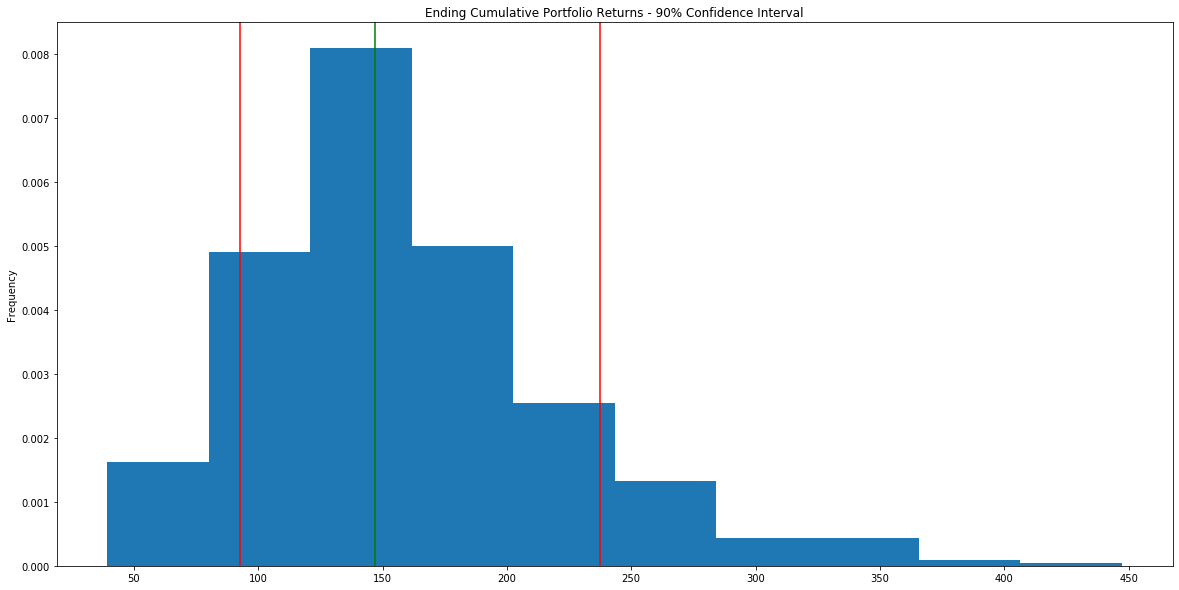

In [62]:
# YOUR CODE HERE
# Visualize the distribution of the ending returns
# YOUR CODE HERE
print(confidence_interval_10_90)
print(confidence_interval_50_50)
plt.figure();
portfolio_cumulative_returns_30.plot(kind='hist', title= "Ending Cumulative Portfolio Returns - 90% Confidence Interval", density=True, bins=10, figsize=(20,10))
plt.axvline(confidence_interval_10_90.iloc[0], color='r')
plt.axvline(confidence_interval_10_90.iloc[1], color='r')
plt.axvline(confidence_interval_50_50.iloc[1], color='g')